# Mask Decoder Test

In [1]:
# Libraries
import faiss
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import json
from PIL import Image

from preprocessing import preprocessing_dinov2, preprocessing_sam2

In [2]:
from model.modeling.retrieval import Retrieval
from model.modeling.memory_encoder import MemoryEncoder
from model.modeling.mask_decoder import MaskDecoder

retrieval = Retrieval()
memoryencoder = MemoryEncoder()
maskdecoder = MaskDecoder()

Using cache found in /home/kdh/.cache/torch/hub/facebookresearch_dinov2_main
/home/kdh/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/kdh/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/kdh/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [3]:
# 0. 쿼리 이미지 로딩
import torchvision.transforms.functional as TF
query_img = TF.to_tensor(Image.open("/home/kdh/code/BME_Capstone1/FAISS/A00028185_axial_111.png"))

# 1. retrieval
retrieved = retrieval(query_img, n=8)

# 2. memory encoding
memory, memory_pos = memoryencoder(retrieved)
memory

tensor([[[[-1.7045e+00, -1.7785e+00, -1.9557e+00,  ..., -2.3225e+00,
           -2.7273e+00, -2.3303e+00],
          [-2.1163e+00, -7.9216e-01, -1.0051e+00,  ..., -1.6746e+00,
           -2.4406e+00, -1.6799e+00],
          [-2.5265e+00, -1.9301e+00, -1.8136e+00,  ..., -1.8897e+00,
           -7.4232e-01, -1.6545e+00],
          ...,
          [-2.5734e+00, -1.2340e+00, -8.9362e-01,  ...,  3.1328e-01,
           -9.7026e-01, -5.7288e-01],
          [-1.8127e+00, -1.5109e+00, -1.5063e+00,  ..., -3.8317e-01,
           -1.0427e+00, -7.5340e-01],
          [-2.0458e+00, -1.0479e+00, -1.2309e+00,  ..., -1.2992e-01,
           -9.6754e-01, -8.7377e-01]],

         [[-1.4251e-01, -5.9394e-01, -1.6818e-01,  ..., -4.0298e-01,
           -9.2527e-01, -1.7585e-01],
          [-5.2374e-01, -1.4852e-01, -6.2037e-02,  ...,  8.5277e-02,
           -8.3191e-01,  4.8055e-01],
          [-8.4021e-01, -1.4950e+00, -5.6247e-01,  ..., -9.7402e-01,
           -1.0369e+00, -4.3648e-01],
          ...,
     

In [4]:
masks = maskdecoder(query_img, memory, memory_pos)

In [6]:
masks.shape

torch.Size([1, 1, 256, 256])

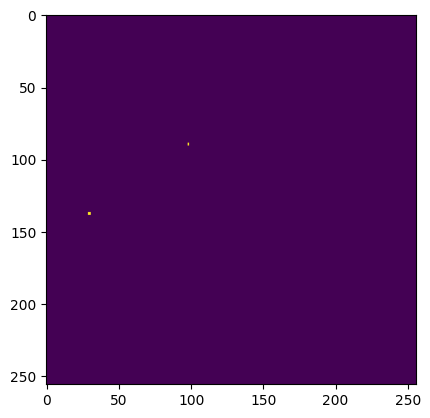

In [7]:
plt.imshow(masks.detach().cpu().numpy()[0, 0]>0)

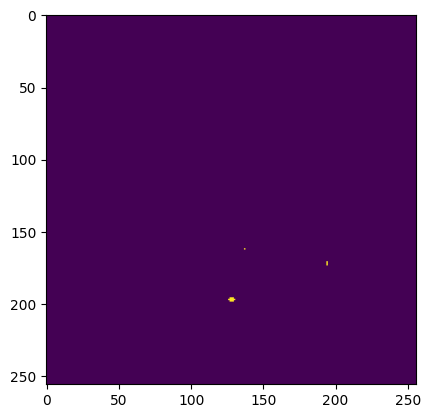

In [13]:
plt.imshow(masks[4][0, 0].detach().cpu().numpy()>0.0)

(-0.5, 191.5, 255.5, -0.5)

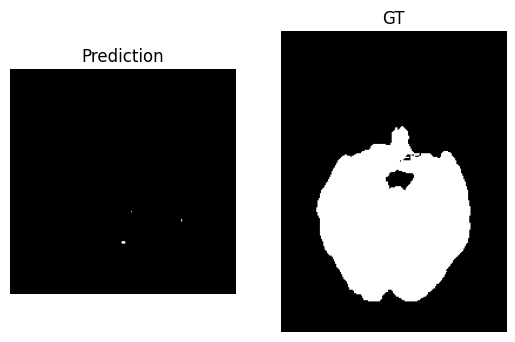

In [16]:
plt.subplot(1, 2, 1)
plt.imshow(masks[4][0, 0].detach().cpu().numpy()>0.0, cmap='gray')
plt.title('Prediction')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(Image.open("/home/kdh/code/BME_Capstone1/FAISS/A00028185_axial_111_mask.png"), cmap='gray')
plt.title('GT')
plt.axis('off')

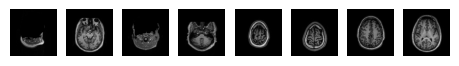

In [14]:
for i in range(len(retrieved['image'])):
    plt.subplot(1, len(retrieved['image'])+1, i+1)
    plt.imshow(retrieved['image'][i].permute(1,2,0))
    plt.axis('off')

In [20]:
memory_pos

'vision_pos_enc'

In [ ]:

# 3. predict
masks = predict(query_img, memory, memory_pos, memory_encoder.sam2)

In [4]:
# Examaple: Use 3 Images as Memory
memory_image_1 = Image.open('/home/kdh/code/BME_Capstone1/FAISS/A00028185_axial_107.png')
memory_label_1 = Image.open('/home/kdh/code/BME_Capstone1/FAISS/A00028185_axial_107_mask.png')

memory_image_2 = Image.open('/home/kdh/code/BME_Capstone1/FAISS/A00028185_axial_108.png')
memory_label_2 = Image.open('/home/kdh/code/BME_Capstone1/FAISS/A00028185_axial_108_mask.png')

memory_image_3 = Image.open('/home/kdh/code/BME_Capstone1/FAISS/A00028185_axial_109.png')
memory_label_3 = Image.open('/home/kdh/code/BME_Capstone1/FAISS/A00028185_axial_109_mask.png')

In [5]:
import torchvision.transforms.functional as TF
from sam2.sam2_video_predictor import SAM2VideoPredictor
sam2encoder = SAM2VideoPredictor.from_pretrained("facebook/sam2-hiera-large").cuda().image_encoder
imgfeat = preprocessing_sam2(memory_image_1).cuda()
imgfeat = sam2encoder(imgfeat.unsqueeze(0))
imgfeat

{'vision_features': tensor([[[[-1.3193, -0.0694, -0.9285,  ..., -0.7206, -1.1850, -1.4390],
           [-0.6242, -0.1087, -0.9664,  ...,  0.3130, -0.6732, -0.8572],
           [-0.5647, -0.8858, -0.7806,  ...,  0.0435, -1.1005, -1.7898],
           ...,
           [ 0.6891,  0.1611,  0.5958,  ...,  1.6353, -0.3159, -0.3968],
           [-1.1029,  0.2445, -0.0955,  ..., -0.3891, -0.3629, -0.9065],
           [-0.1730,  0.4571,  0.6185,  ...,  0.3924, -0.1588, -0.5341]],
 
          [[-0.5305, -1.3069, -1.7122,  ..., -1.5378, -1.5769, -1.0747],
           [-1.0818, -0.5898, -1.2232,  ..., -0.2914, -1.0734, -1.1883],
           [-0.0937, -1.1652, -0.1516,  ..., -0.3263, -0.3373, -0.5695],
           ...,
           [-0.5170,  0.1291, -1.3645,  ..., -0.3424, -0.6797, -0.4010],
           [ 0.0130, -0.8647,  0.3604,  ...,  0.1397, -0.8438, -0.9440],
           [-0.5489, -0.9942, -1.1245,  ..., -0.3907, -1.0485, -0.8965]],
 
          [[ 0.7976,  0.6573, -0.1986,  ..., -0.3909, -0.2398, -0.2

In [6]:
retriev = retrieval(TF.to_tensor(memory_image_1).squeeze(0))
memorybank = memoryencoder(retriev)
memorybank

{'vision_features': tensor([[[[-1.2063e+00, -9.3181e-01, -1.4267e+00,  ..., -8.8146e-02,
            -1.7401e+00, -1.9437e+00],
           [-1.4177e+00,  2.8754e-01, -6.0043e-01,  ..., -2.7078e-01,
            -2.1788e+00, -1.3100e+00],
           [-3.1527e+00, -6.4916e-01, -1.4307e+00,  ..., -8.8521e-01,
            -7.0030e-01, -1.3715e+00],
           ...,
           [-1.7052e+00, -2.2550e-01, -2.4596e-01,  ...,  2.6853e+00,
             1.0935e+00,  9.7386e-01],
           [-1.4629e+00, -3.2294e-01, -1.3479e+00,  ...,  1.2079e+00,
            -3.2976e-01, -6.6513e-01],
           [-1.8964e+00, -6.7577e-01, -1.0031e+00,  ...,  4.9742e-01,
            -6.6715e-01, -7.9894e-01]],
 
          [[-1.2995e-01, -3.3054e-01, -2.4991e-01,  ...,  2.3020e-01,
             2.6457e-01, -1.8260e-02],
           [-6.0881e-01, -3.0612e-01, -1.1626e+00,  ..., -9.1510e-01,
            -7.4209e-01,  1.7165e-01],
           [-3.8405e-01, -2.6499e-01, -1.6572e+00,  ..., -6.4929e-01,
            -9.9086e

In [7]:
memorybank['vision_features'].shape

torch.Size([3, 64, 16, 12])

In [8]:
memorybank['vision_pos_enc'][0].shape

torch.Size([3, 64, 16, 12])

In [9]:
featwithmem = memoryattention(imgfeat, memorybank)

torch.Size([192, 3, 256])
torch.Size([192, 3, 256])
torch.Size([192, 3, 64])
torch.Size([192, 3, 64])


In [10]:
featwithmem.shape

torch.Size([192, 3, 256])

In [12]:
featwithmem.permute(1, 2, 0).view(3, 256, 16, 12).shape

torch.Size([3, 256, 16, 12])

In [13]:
predictor = SAM2VideoPredictor.from_pretrained("facebook/sam2-hiera-large").cuda()
predictor.sam_mask_decoder(featwithmem)

TypeError: MaskDecoder.forward() missing 5 required positional arguments: 'image_pe', 'sparse_prompt_embeddings', 'dense_prompt_embeddings', 'multimask_output', and 'repeat_image'

In [ ]:
(
    low_res_multimasks,
    ious,
    sam_output_tokens,
    object_score_logits,
) = predictor.sam_mask_decoder(
    image_embeddings=backbone_features,
    image_pe=image_pe,
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=multimask_output,
    repeat_image=False,  # the image is already batched
    high_res_features=high_res_features,
)

In [18]:

predictor._prepare_memory_conditioned_features

<bound method SAM2Base._prepare_memory_conditioned_features of SAM2VideoPredictor(
  (image_encoder): ImageEncoder(
    (trunk): Hiera(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 144, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      )
      (blocks): ModuleList(
        (0-1): 2 x MultiScaleBlock(
          (norm1): LayerNorm((144,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=144, out_features=432, bias=True)
            (proj): Linear(in_features=144, out_features=144, bias=True)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((144,), eps=1e-06, elementwise_affine=True)
          (mlp): MLP(
            (layers): ModuleList(
              (0): Linear(in_features=144, out_features=576, bias=True)
              (1): Linear(in_features=576, out_features=144, bias=True)
            )
            (act): GELU(approximate='none')
          )
        )
        (2): MultiSca

In [1]:
B = 1   # batch size
C = 256 # hidden dim
H, W = 30, 40 # feature map 크기 (top level)
M = 600 # memory token 수 (예: 과거 3프레임 × 200개 token씩)

current_vision_feats = [torch.rand(C, B, H, W)]
current_vision_pos_embeds = [torch.rand(C, B, H, W)]
feat_sizes = [(H, W)]
memory_bank_feats = torch.rand(M, B, C)
memory_bank_pos_embeds = torch.rand(M, B, C)

predictor._prepare_memory_conditioned_features(
    current_vision_feats,
    current_vision_pos_embeds,
    feat_sizes,
    memory_bank_feats,
    memory_bank_pos_embeds,
)

NameError: name 'torch' is not defined

In [20]:
memorybank['vision_features'].shape

torch.Size([3, 64, 16, 12])

In [17]:
retriev['image'][0].shape

torch.Size([3, 256, 192])

In [3]:
from model.modeling.memory_encoder import MemoryEncoder
ME = MemoryEncoder()

In [4]:
import torchvision
memory_image = [memory_image_1, memory_image_2, memory_image_3]
memory_image = [preprocessing_sam2(i) for i in memory_image]
memory_label = [memory_label_1, memory_label_2, memory_label_3]
memory_label = [torchvision.transforms.ToTensor()(i) for i in memory_label]

In [5]:
retrieval = {
    'image' : memory_image,
    'mask' : memory_label
}

ME(retrieval)

{'vision_features': tensor([[[[-7.7338e-01, -9.4070e-01, -1.3448e+00,  ..., -8.8385e-01,
            -1.7215e+00, -1.6507e+00],
           [-7.9590e-01,  8.9334e-01, -2.2156e-02,  ...,  1.2474e-01,
             4.0655e-01,  2.9616e-01],
           [-4.1368e+00,  1.5620e-01, -8.0302e-02,  ...,  1.4600e+00,
             8.2448e-01, -5.5358e-01],
           ...,
           [-1.2828e+00,  9.3782e-01, -1.5289e+00,  ..., -1.3867e+00,
            -3.7491e-01,  4.1072e-01],
           [-1.1484e+00,  5.0259e-01, -3.6948e-02,  ..., -1.0719e+00,
            -6.9324e-01, -1.0450e+00],
           [-1.4029e+00, -5.7596e-01, -4.4822e-01,  ...,  2.4292e-01,
            -1.0280e+00, -1.0164e+00]],
 
          [[ 2.6867e-01, -1.1357e+00, -8.6683e-01,  ..., -8.0661e-01,
            -5.6177e-01, -3.2249e-01],
           [-1.7026e-01, -5.5666e-01, -1.4652e+00,  ..., -1.7965e+00,
            -5.9111e-01,  9.0924e-02],
           [ 1.2772e-01, -5.2776e-01, -1.9151e+00,  ..., -1.4029e+00,
            -4.1242e

In [7]:
me = ME(retrieval)
me['vision_features'].shape

torch.Size([3, 64, 16, 12])

In [8]:
me['vision_pos_enc'][0].shape

torch.Size([3, 64, 16, 12])

In [9]:
input_image = Image.open('/home/kdh/code/BME_Capstone1/FAISS/A00028185_axial_110.png')
input_label = Image.open('/home/kdh/code/BME_Capstone1/FAISS/A00028185_axial_110_mask.png')

In [10]:
from sam2.sam2_video_predictor import SAM2VideoPredictor
predictor = SAM2VideoPredictor.from_pretrained("facebook/sam2-hiera-large").cuda()
predictor

SAM2VideoPredictor(
  (image_encoder): ImageEncoder(
    (trunk): Hiera(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 144, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      )
      (blocks): ModuleList(
        (0-1): 2 x MultiScaleBlock(
          (norm1): LayerNorm((144,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=144, out_features=432, bias=True)
            (proj): Linear(in_features=144, out_features=144, bias=True)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((144,), eps=1e-06, elementwise_affine=True)
          (mlp): MLP(
            (layers): ModuleList(
              (0): Linear(in_features=144, out_features=576, bias=True)
              (1): Linear(in_features=576, out_features=144, bias=True)
            )
            (act): GELU(approximate='none')
          )
        )
        (2): MultiScaleBlock(
          (norm1): LayerNorm((144,), eps=1e-06, elemen

In [11]:
curr_feat = predictor.image_encoder(preprocessing_sam2(input_image).unsqueeze(0).cuda())

In [12]:
curr_feat['vision_features'].shape

torch.Size([1, 256, 16, 12])

In [13]:
me['vision_features'].shape

torch.Size([3, 64, 16, 12])

In [14]:
memory = []
frame = me['vision_features']#[f]
frame = frame.flatten(2)
frame = frame.permute(2, 0, 1)
frame = frame.reshape(-1, frame.shape[-1])
print(frame.shape)

torch.Size([576, 64])


In [15]:
frame = frame.unsqueeze(1).expand(-1, 1, -1)  
# [576, 1, 64]
frame.shape

torch.Size([576, 1, 64])

In [16]:
curr = curr_feat['vision_features']
curr = curr.reshape(curr.shape[0], curr.shape[1], -1)
curr = curr.permute(2, 0, 1)
curr.shape

torch.Size([192, 1, 256])

In [17]:
for i in range(len(curr_feat['vision_pos_enc'])):
    print(f"{i}\t{curr_feat['vision_pos_enc'][i].shape}")

0	torch.Size([1, 256, 64, 48])
1	torch.Size([1, 256, 32, 24])
2	torch.Size([1, 256, 16, 12])


In [18]:
me['vision_pos_enc'][-1].shape

torch.Size([3, 64, 16, 12])

In [19]:
curr_pos = curr_feat['vision_pos_enc'][-1]
curr_pos = curr_pos.reshape(curr_pos.shape[0], curr_pos.shape[1], -1)
curr_pos = curr_pos.permute(2, 0, 1)
curr_pos.shape

torch.Size([192, 1, 256])

In [20]:
memory_pos = me['vision_pos_enc'][-1]
memory_pos = memory_pos.flatten(2).permute(2, 0, 1)
memory_pos = memory_pos.reshape(192*3, 1, 64)
memory_pos.shape

torch.Size([576, 1, 64])

In [21]:
ma = predictor.memory_attention(
    curr=curr,
    curr_pos=curr_pos,
    memory=frame,
    memory_pos=memory_pos,
)

In [22]:
ma.shape

torch.Size([192, 1, 256])

In [23]:
ma_feat = ma.permute(1,2,0).view(1, 256, 16, 12)
ma_feat.shape

torch.Size([1, 256, 16, 12])

In [25]:
predictor.sam_mask_decoder

MaskDecoder(
  (transformer): TwoWayTransformer(
    (layers): ModuleList(
      (0-1): 2 x TwoWayAttentionBlock(
        (self_attn): Attention(
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (cross_attn_token_to_image): Attention(
          (q_proj): Linear(in_features=256, out_features=128, bias=True)
          (k_proj): Linear(in_features=256, out_features=128, bias=True)
          (v_proj): Linear(in_features=256, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=256, bias=True)
        )
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (layers): ModuleList(
    